<a href="https://colab.research.google.com/github/yoonhero/Brainstormers/blob/master/paperwithcode/Auto_Encoding_Variational_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

saved_loc = os.path.join('/content/MyDrive/MyDrive/VAE_Result', current_time)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)

writer = SummaryWriter(saved_loc)
nb_epochs = 50
batch_size = 200

cuda
저장 위치:  /content/MyDrive/MyDrive/VAE_Result/2023-01-24-00:14


In [6]:
# Transformer code
transformer = transforms.Compose([
            transforms.ToTensor()
])


# Loading trainset, testset and trainloader, testloader
trainset = torchvision.datasets.MNIST(root = '/content/MNIST', train = True,
                                        download = True, transform = transformer)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)


testset = torchvision.datasets.MNIST(root = '/content/MNIST', train = False,
                                        download = True, transform = transformer)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = 2)

<class 'torch.Tensor'>
torch.Size([3, 32, 242])


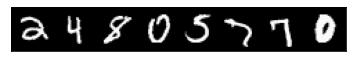

In [7]:
# sample check
sample, label = next(iter(trainloader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

In [8]:
class VAE(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2,latent_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(image_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc31 = nn.Linear(hidden_size_2, latent_size)
        self.fc32 = nn.Linear(hidden_size_2, latent_size)

        self.fc4 = nn.Linear(latent_size, hidden_size_2)
        self.fc5 = nn.Linear(hidden_size_2, hidden_size_1)
        self.fc6 = nn.Linear(hidden_size_1, image_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + std * eps

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu,logvar)
        return self.decode(z), mu, logvar

In [10]:
VAE_model = VAE(28*28, 512, 256, 2).to(DEVICE)
optimizer = optim.Adam(VAE_model.parameters(), lr=1e-3)

In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1+logvar-mu.pow(2) - logvar.exp())

    return BCE, KLD

In [13]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        BCE, KLD = loss_function(recon_batch, data, mu, logvar)

        loss = BCE + KLD 

        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )

        loss.backward()

        train_loss += loss.item()

        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)
    ))        

In [14]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(DEVICE)
            
            recon_batch, mu, logvar = model(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)

            loss = BCE + KLD

            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]]) # (16, 1, 28, 28)
                grid = torchvision.utils.make_grid(comparison.cpu()) # (3, 62, 242)
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [15]:
def latent_to_image(epoch, model):
    with torch.no_grad():
        sample = torch.randn(64, 2).to(DEVICE)
        recon_image = model.decode(sample).cpu()
        grid = torchvision.utils.make_grid(recon_image.view(64, 1, 28, 28))
        writer.add_image("Latent To Image", grid, epoch)

In [16]:
for epoch in tqdm(range(0, nb_epochs)):
    train(epoch, VAE_model, trainloader, optimizer)
    test(epoch, VAE_model, testloader)
    print("\n")
    latent_to_image(epoch, VAE_model)

writer.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 543.861875
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 183.265586
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 167.975273
======> Epoch: 0 Average loss: 186.4085


Train Epoch: 1 [0/60000 (0%)]	 Loss: 163.699707
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 155.727676
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 154.352998
======> Epoch: 1 Average loss: 158.6222


Train Epoch: 2 [0/60000 (0%)]	 Loss: 154.645791
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 152.797422
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 150.965449
======> Epoch: 2 Average loss: 152.6512


Train Epoch: 3 [0/60000 (0%)]	 Loss: 151.965586
Train Epoch: 3 [20000/60000 (33%)]	 Loss: 147.715752
Train Epoch: 3 [40000/60000 (67%)]	 Loss: 147.934902
======> Epoch: 3 Average loss: 149.7907


Train Epoch: 4 [0/60000 (0%)]	 Loss: 145.116592
Train Epoch: 4 [20000/60000 (33%)]	 Loss: 147.811084
Train Epoch: 4 [40000/60000 (67%)]	 Loss: 149.266895
======> Epoch: 4 Average loss: 147.7033


Train Epoch: 5 [0/60

In [ ]:
%load_ext tensorboard

%tensorboard --logdir='/content/MyDrive/MyDrive/VAE_Result/2023-01-24-00:14'